## Imports

In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Loading the ResNet50 model

In [2]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3),pooling='max')

In [3]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

## Feature Extraction

In [15]:
def feature_extract(img_path, model):
    input_shape = (224, 244, 3)
    img = image.load_img(img_path, target_size=(imput_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

## Loading the Caltech 256 Image Dataset

In [16]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                filepath = os.path.join(root, filename)
                if os.path.exists(filepath):
                    file_list.append(filepath)
                else:
                    print(filepath)
    return file_list

In [17]:
root_dir = '256_ObjectCategories'
filenames = sorted(get_file_list(root_dir))
print(len(filenames))

30607


In [18]:
BATCH_SIZE = 128

dataset = tf.keras.utils.image_dataset_from_directory(root_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=(224,224))
num_images = len(dataset.file_paths)
num_epochs = int(math.ceil(num_images / BATCH_SIZE))

start_time = time.time()
feature_list = []
feature_list = model.predict(dataset, num_epochs)
end_time = time.time()

Found 30607 files belonging to 257 classes.
240/240 [==============================] - 1989s 8s/step


In [19]:
for i, features in enumerate(feature_list):
    feature_list[i] = features / norm(features)
    
feature_list = feature_list.reshape(len(feature_list), -1)
print("Number of images: ", len(dataset.file_paths))
print("Shape of feature_list: ", feature_list.shape)
print("Time taken in min: ", (end_time - start_time)/60)

Number of images:  30607
Shape of feature_list:  (30607, 2048)
Time taken in min:  33.16046410004298


In [20]:
pickle.dump(dataset.class_names, open('./class_ids-caltech256.pickle', 'wb'))
pickle.dump(dataset.file_paths, open('./filenames-caltech256.pickle', 'wb'))
pickle.dump(feature_list, open('./features-caltech256-' + 'resnet50' + '.pickle', 'wb'))

## Similarity Search

In [4]:
filenames = pickle.load(open('./filenames-caltech256.pickle', 'rb'))
feature_list = pickle.load(open('./features-caltech256-resnet50.pickle', 'rb'))
class_ids = pickle.load(open('./class_ids-caltech256.pickle', 'rb'))

In [5]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images: ",num_images)
print("Number of features per image: ", num_features_per_image)

Number of images:  30607
Number of features per image:  2048


In [6]:
feature_list.shape

(30607, 2048)

In [7]:
len(class_ids)

257

In [8]:
random_index = random.randint(0, num_images)

## Using KNN for similarity search

In [33]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[random_index]])

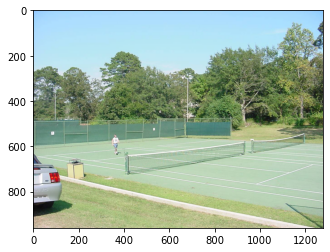

In [34]:
plt.imshow(mpimg.imread(filenames[random_index]))

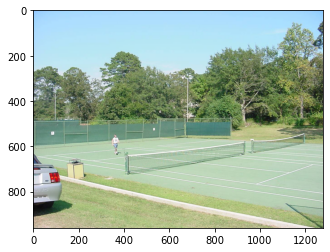

In [35]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]))

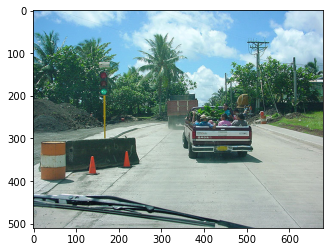

In [36]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]))

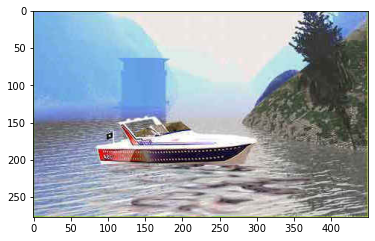

In [37]:
plt.imshow(mpimg.imread(filenames[indices[0][2]]))

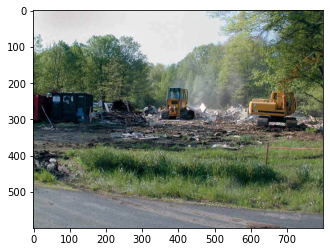

In [38]:
plt.imshow(mpimg.imread(filenames[indices[0][3]]))

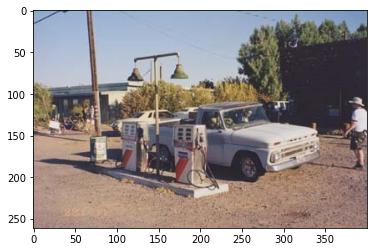

In [39]:
plt.imshow(mpimg.imread(filenames[indices[0][4]]))

In [40]:
for i in range(5):
    print(distances[0][i])

0.0
0.70680934
0.72840786
0.72885346
0.7346079


In [41]:
def classname_filename(str):
    return str.split('\\')[-2] + str.split('\\')[-1]

def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(int(len(images) / columns + 1), columns, i+1)
        if i==0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) + "\nDistance: " + str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)

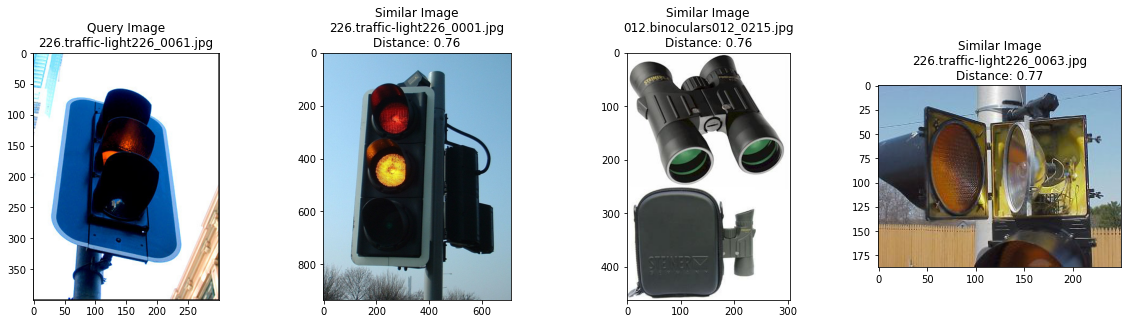

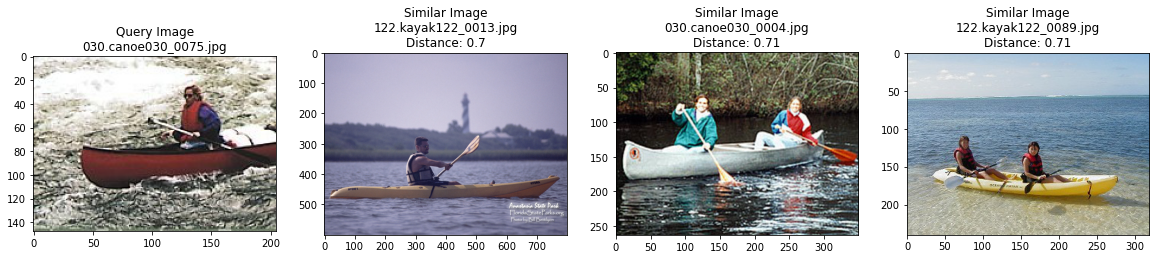

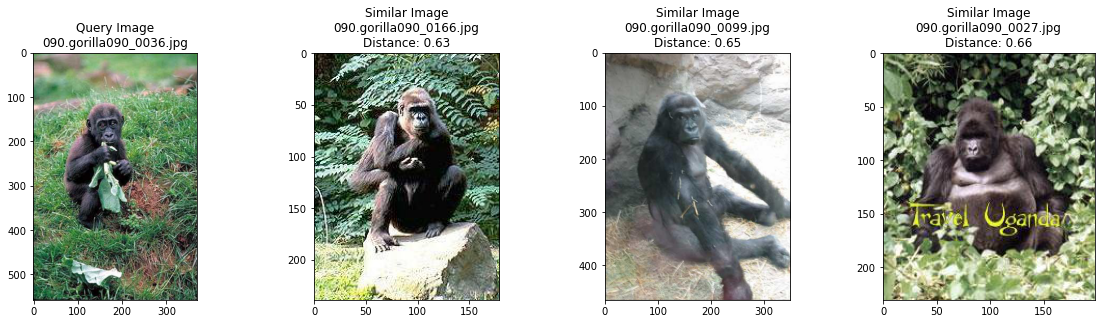

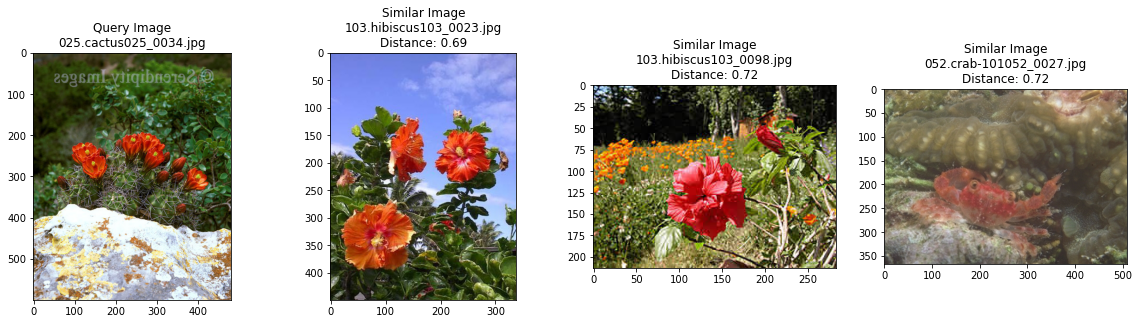

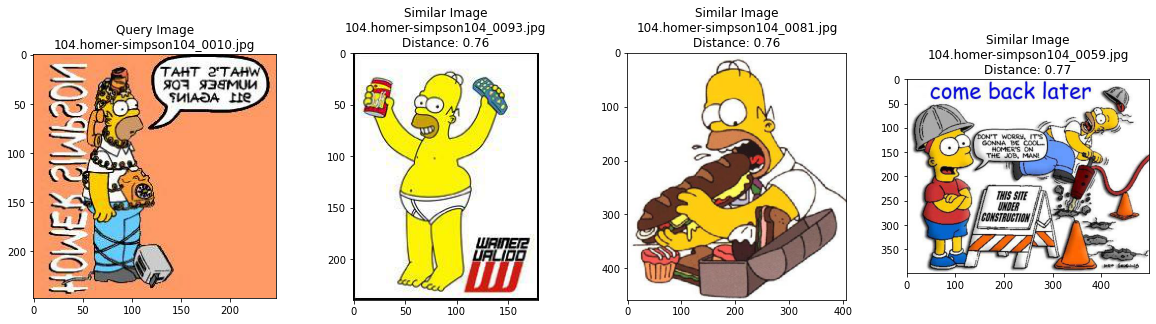

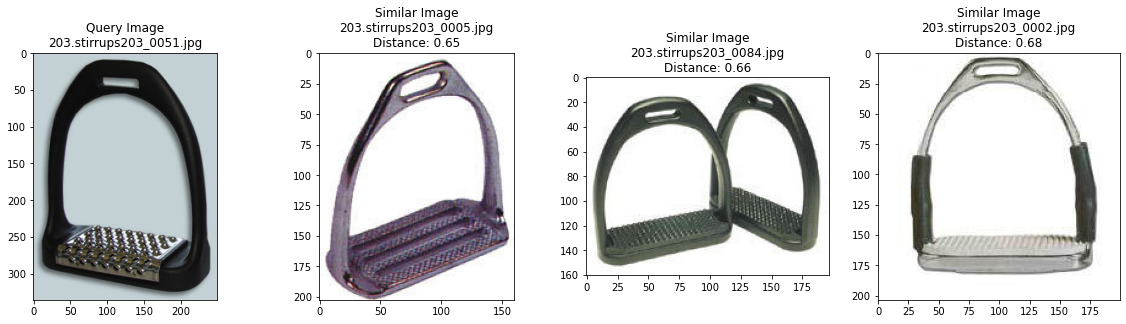

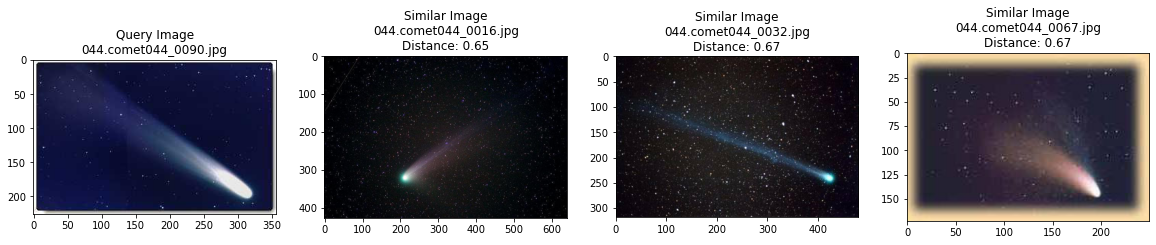

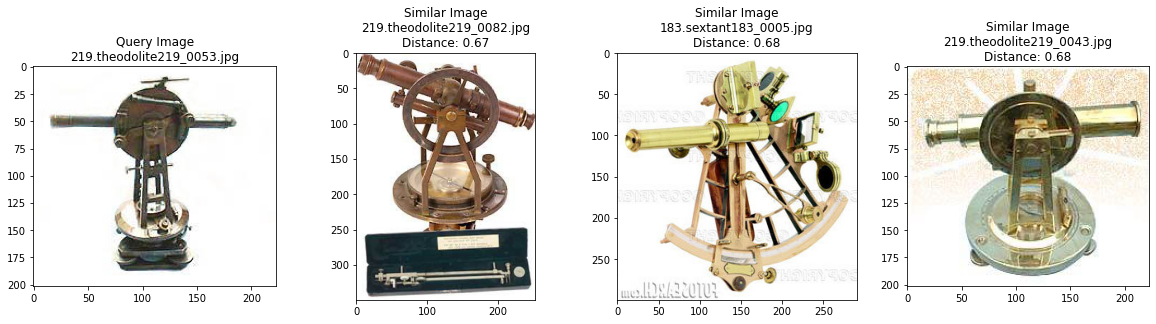

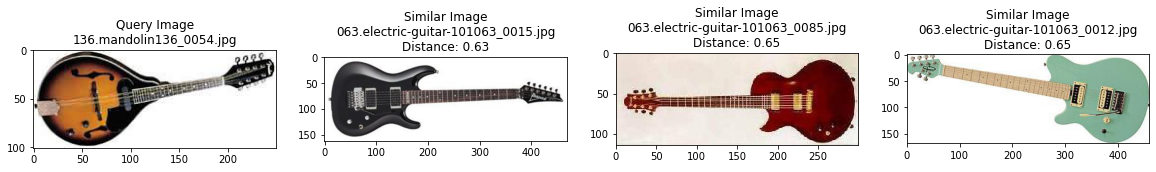

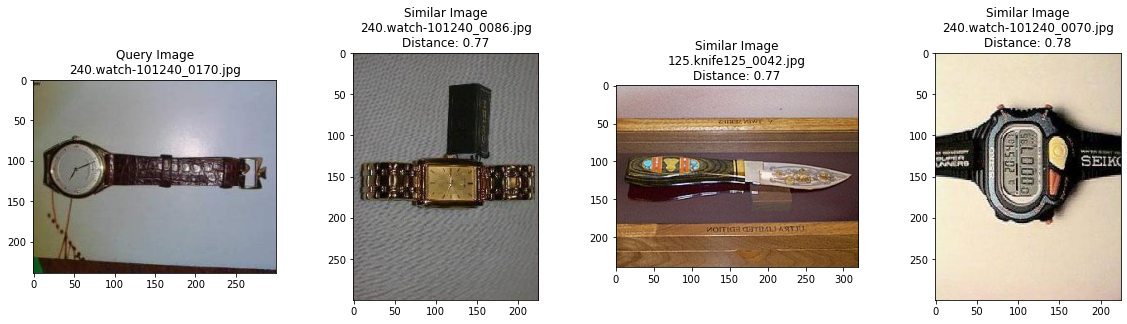

In [42]:
for i in range(10):
    random_image_index = random.randint(0, 30000)
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

In [19]:
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ", np.median(distances[:, 2]))

Median distance between all photos:  0.7531973
Max distance between all photos:  0.75922155
Median distance among most similar photos:  0.7531973


## Calculating accuracy of Brute Force Model

In [37]:
def classname(str):
    return str.split('\\')[-2]

def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5;
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors = num_nearest_neighbors, algorithm = 'brute', metric = 'euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(filenames[indices[0][j]])):
                correct_prediction+=1
            else:
                incorrect_prediction+=1
    end = time.time()
    accuracy = round(100.0 * correct_prediction / (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [27]:
print("Accuracy on original feature set: ", calculate_accuracy(feature_list[:]))

Accuracy on original feature set:  (67.22, 14513.342093229294)
